In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


import sys
path_to_mavenn_local = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local'
sys.path.insert(0,path_to_mavenn_local)

import mavenn

In [2]:
# from mavenn.src.utils import get_example_dataset

# get_example_dataset(name='Sort-Seq')

In [3]:
#data_df = pd.read_csv('Sort_seq_vector_fmt_input.csv',index_col=[0])
experiment_name = 'full-wt'

data_df = pd.read_csv(experiment_name+'.csv',index_col=[0])

In [4]:
sequences = data_df['seq'].values

In [5]:
# full-wt sequence index = 36:75

# get correct part of sequence
temp_seqs_array = data_df['seq'].values
correct_seqs_list = []
for seq_index in range(len(sequences)):
    
    correct_seqs_list.append(temp_seqs_array[seq_index][36:75])

In [6]:
#sequences = data_df['seq'].values
sequences = np.array(correct_seqs_list)
bin_counts = data_df['bin'].values
ct_n = data_df['ct'].values

In [7]:
data_df = pd.DataFrame({'seq':sequences,'bin':bin_counts,'ct':ct_n})

In [8]:
#data_df.drop_duplicates(['foo','bar'])
data_df = data_df.drop_duplicates(['seq']).copy()

In [9]:
# from mavenn.src.utils import vec_data_to_mat_data

# ct_my, x_m, = vec_data_to_mat_data(x_n=data_df['seq'], 
#                                    y_n=data_df['bin'],
#                                    ct_n=data_df['ct'])

In [10]:
#data_df.to_csv('full-wt-sort_seq.csv')
#pd.read_csv('full-wt-sort_seq.csv',index_col=[0])

In [11]:
# from mavenn.src.utils import vec_data_to_mat_data

# ct_my, x_m, = vec_data_to_mat_data(x_n=data_df['seq'], 
#                                    y_n=data_df['bin'],
#                                    ct_n=data_df['ct'])

sequences = data_df['seq'].values
bin_counts = data_df['bin'].values
ct_n = data_df['ct'].values

In [12]:
NAR = mavenn.Model(regression_type='MPA',
                   x=sequences, 
                   y=bin_counts, 
                   ct_n = ct_n,
                   gpmap_type='additive',
                   alphabet='dna',
                   theta_regularization=0.001,
                   ohe_batch_size=50000)



In [13]:
NAR.get_nn().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_labels_input (InputLay (None, 166)          0                                            
__________________________________________________________________________________________________
Sequence_only (Lambda)          (None, 156)          0           Sequence_labels_input[0][0]      
__________________________________________________________________________________________________
phi (Dense)                     (None, 1)            157         Sequence_only[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           100         phi[0][0]                        
__________________________________________________________________________________________________
yhat (Dens

In [14]:
NAR.fit(epochs=50, 
        learning_rate=0.0005,
        early_stopping=True, 
        early_stopping_patience=5, 
        verbose=1)

Train on 36622 samples, validate on 9156 samples
Epoch 1/50
36622/36622 [==============================] - 1s 40us/step - loss: 98.0776 - val_loss: 97.8851
Epoch 2/50
36622/36622 [==============================] - 1s 31us/step - loss: 95.0116 - val_loss: 93.6801
Epoch 3/50
36622/36622 [==============================] - 1s 30us/step - loss: 90.4761 - val_loss: 91.3791
Epoch 4/50
36622/36622 [==============================] - 1s 33us/step - loss: 88.9986 - val_loss: 91.0840
Epoch 5/50
36622/36622 [==============================] - 1s 29us/step - loss: 88.6289 - val_loss: 90.5520
Epoch 6/50
36622/36622 [==============================] - 1s 29us/step - loss: 88.4187 - val_loss: 90.5532
Epoch 7/50
36622/36622 [==============================] - 1s 32us/step - loss: 88.2614 - val_loss: 89.9386
Epoch 8/50
36622/36622 [==============================] - 1s 31us/step - loss: 88.1827 - val_loss: 89.9427
Epoch 9/50
36622/36622 [==============================] - 1s 30us/step - loss: 88.1210 - val_lo

In [15]:
NAR.get_nn().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_labels_input (InputLay (None, 166)          0                                            
__________________________________________________________________________________________________
Sequence_only (Lambda)          (None, 156)          0           Sequence_labels_input[0][0]      
__________________________________________________________________________________________________
phiPrime (Dense)                (None, 1)            157         Sequence_only[0][0]              
__________________________________________________________________________________________________
fix_diffeomorphic_mode (fixDiff (None, 1)            0           phiPrime[0][0]                   
__________________________________________________________________________________________________
phi (Dense

In [16]:
loss_history = NAR.model.history

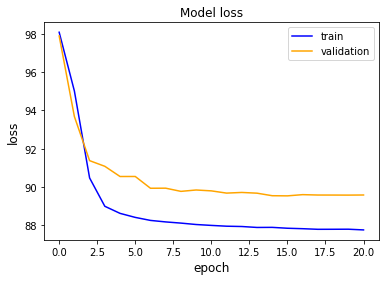

In [17]:
plt.plot(loss_history.history['loss'], color='blue')
plt.plot(loss_history.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])
plt.show()

In [18]:
NAR.get_nn()

In [19]:
phi = NAR.x_to_phi(sequences)

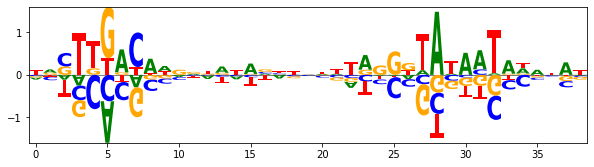

In [20]:
import logomaker
#theta_df = pd.DataFrame(NAR.get_nn().layers[2].get_weights()[0].reshape(39,4),columns=['A','C','G','T'])
theta_df = pd.DataFrame(NAR.get_gpmap_parameters()['value'].values[1:].reshape(39,4),columns=['A','C','G','T'])
logomaker.Logo(theta_df,center_values=False)

In [21]:
phi_range = np.linspace(min(phi),max(phi),1000)

In [22]:
p_of_all_y_given_phi = NAR.na_p_of_all_y_given_phi(phi_range)

In [23]:
# import seaborn as sns
# fig, ax = plt.subplots(figsize=(6,4))
# if p_of_all_y_given_phi.T[p_of_all_y_given_phi.T.shape[0]-1][0]>p_of_all_y_given_phi.T[p_of_all_y_given_phi.T.shape[0]-1][p_of_all_y_given_phi.T.shape[1]-1]:
#     ax = sns.heatmap(pd.DataFrame(p_of_all_y_given_phi.T).loc[::1,::-1],cmap='Greens')
# else:
#     ax = sns.heatmap(p_of_all_y_given_phi.T,cmap='Greens')    
# ax.invert_yaxis()
# ax.set_xticks(([0,int(len(phi_range)/2),len(phi_range)-2]), minor=False)
# middle_tick = str(phi_range[int(len(phi_range)/2)])
# ax.set_xticklabels(([str(phi_range[0])[0:5],middle_tick[0:2],str(phi_range[len(phi_range)-1])[0:5]]), minor=False)

[Text(0.5, 0, '-8.20'), Text(39.5, 0, '-2'), Text(78.5, 0, '3.220')]

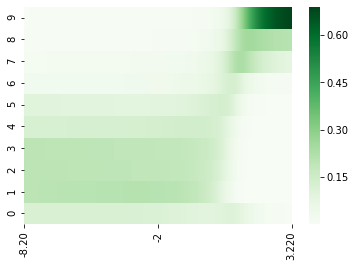

In [25]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
# if p_of_all_y_given_phi.T[p_of_all_y_given_phi.T.shape[0]-1][0]>p_of_all_y_given_phi.T[p_of_all_y_given_phi.T.shape[0]-1][p_of_all_y_given_phi.T.shape[1]-1]:
#     ax = sns.heatmap(pd.DataFrame(p_of_all_y_given_phi.T).loc[::1,::-1],cmap='Greens')
# else:
ax = sns.heatmap(p_of_all_y_given_phi.T,cmap='Greens')    
ax.invert_yaxis()
ax.set_xticks(([0,int(len(phi_range)/2),len(phi_range)-2]), minor=False)
middle_tick = str(phi_range[int(len(phi_range)/2)])
ax.set_xticklabels(([str(phi_range[0])[0:5],middle_tick[0:2],str(phi_range[len(phi_range)-1])[0:5]]), minor=False)

In [27]:
#NAR.save('model_files/'+experiment_name)

In [ ]:
#mi_continuous(phi,bin_counts)
NAR.I_predictive(sequences,bin_counts,uncertainty=True)

In [ ]:
#pd.DataFrame(p_of_all_y_given_phi.T).loc[::-1].to_csv('results/5_full_0/noise_model_df.csv')

In [ ]:
#pd.DataFrame(NAR.get_gpmap_parameters()['value'].values[1:].reshape(39,4),columns=NAR.model.characters).to_csv('results/5_full_0/inferred_logo.csv')



In [ ]:
# full-wt: (0.3587946407040896, 0.005441512551826926)
# rnap-wt: (0.8075633419496506, 0.006950375727335761)
# full-500:  (0.4583881904855962, 0.0071088068293717575)
# full-150: (0.5068673208161183, 0.007100658117906248)
# full-0: (0.5391017416893755, 0.006851182050371136)